Importing the necessities


In [2]:
#importing the lib
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

Loading the dataset 


In [3]:
import chardet
with open("spam.csv", 'rb') as f:
    result = chardet.detect(f.read())
df = pd.read_csv("spam.csv", encoding=result['encoding'])


In [4]:
#overviewing the dataset 
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
2854,ham,Your gonna be the death if me. I'm gonna leave...,NaN,NaN,NaN
581,ham,Ok anyway no need to change with what you said,NaN,NaN,NaN
3562,spam,Auction round 4. The highest bid is now å£54. ...,NaN,NaN,NaN
5286,ham,I'm still pretty weak today .. Bad day ?,NaN,NaN,NaN
4789,ham,Yup. Izzit still raining heavily cos i'm in e ...,NaN,NaN,NaN


Data Cleaning 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


From above , we can clearly see in columns 2,3 and 4 most of the values are null . So , dropping them is the best.

In [6]:
#dropping last three columns 
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [7]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
#renaming the columns , since there are not informative 
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.sample(5)

,target,text
4923,ham,We can go 4 e normal pilates after our intro...
3333,ham,"That's fine, have him give me a call if he kno..."
608,ham,Neva mind it's ok..
3226,ham,Wife.how she knew the time of murder exactly
2164,ham,"Nothing really, just making sure everybody's u..."


In [9]:
#label encoding 
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df.target=encoder.fit_transform(df['target'])
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
#missing values 
df.isnull().sum()

target    0
text      0
dtype: int64

In [11]:
#duplicate values 
df.duplicated().sum()

np.int64(403)

In [12]:
df.shape


(5572, 2)

In [13]:
df.drop_duplicates(keep='first',inplace=True)
df.shape

(5169, 2)

EDA

In [14]:
#checking data distribution of spam or ham 
df.target.value_counts()

target
0    4516
1     653
Name: count, dtype: int64

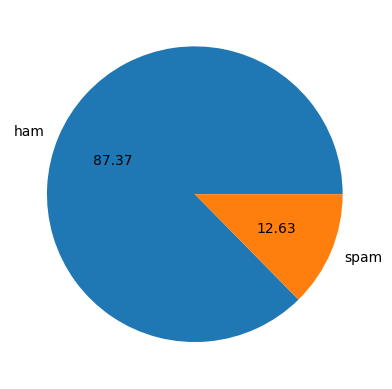

In [15]:
plt.pie(df.target.value_counts(),labels=['ham','spam'],autopct="%.2f")
plt.show()

from above , it can be seen that the data is imbalance 

In [16]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [17]:
#numver of characters in text
df['num_character']=df.text.apply(len)
df.head()

,target,text,num_character
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [18]:
#numbers of words
df['num_words']=df.text.apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,target,text,num_character,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [19]:
#numbers of sentences
df['num_sent']=df.text.apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,target,text,num_character,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [20]:
df.describe()

,target,num_character,num_words,num_sent
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.455794,1.965564
std,0.332253,58.236293,13.324758,1.448541
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,38.000000


In [21]:
#ham
df[df.target==0][['num_character','num_words','num_sent']].describe()

,num_character,num_words,num_sent
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [23]:
#spam
df[df.target==1][['num_character','num_words','num_sent']].describe()


,num_character,num_words,num_sent
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


In [24]:
import seaborn as sns

<Axes: xlabel='num_character', ylabel='Count'>

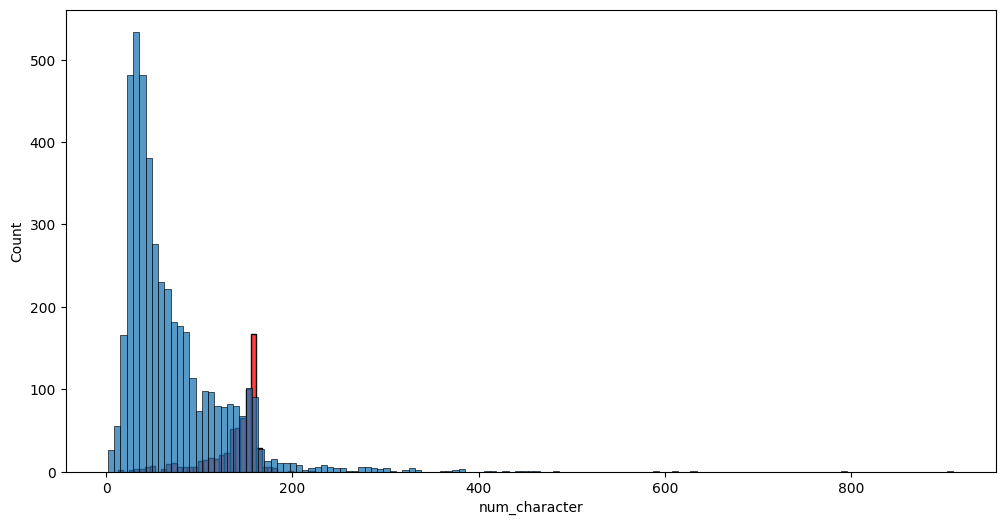

In [30]:
plt.figure(figsize=(12,6))
sns.histplot(df[df.target==1]['num_character'],color='red')
sns.histplot(df[df.target==0]['num_character'])


<Axes: xlabel='num_words', ylabel='Count'>

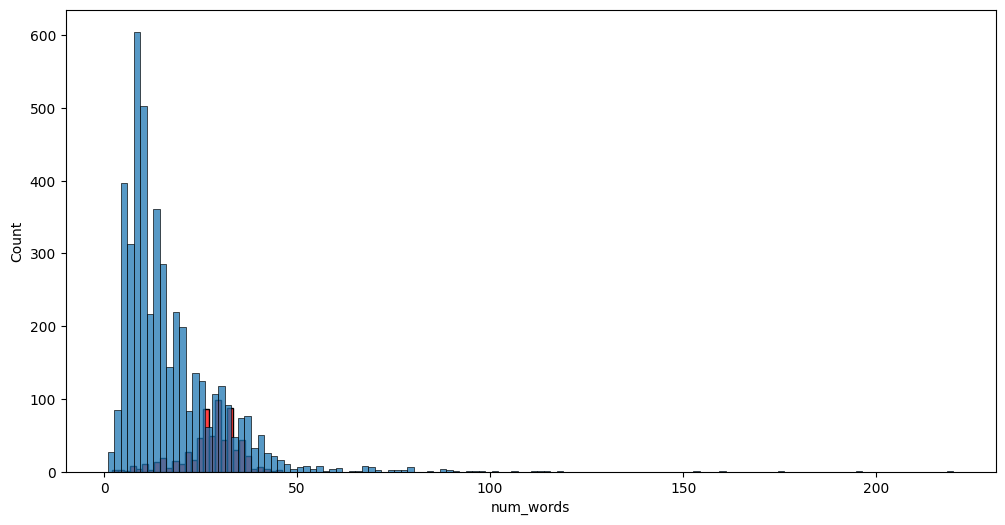

In [31]:
plt.figure(figsize=(12,6))
sns.histplot(df[df.target==1]['num_words'],color='red')
sns.histplot(df[df.target==0]['num_words'])

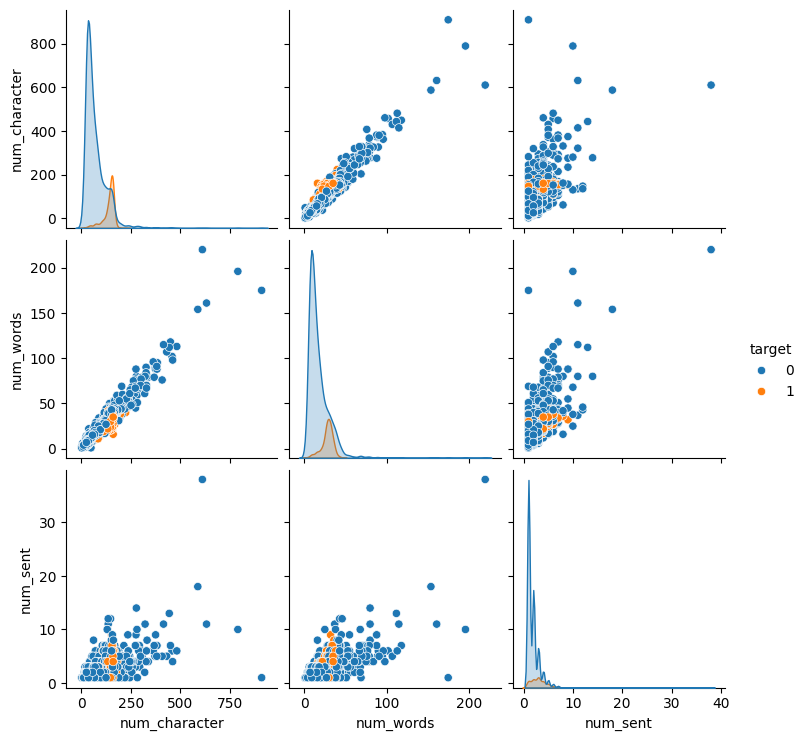

In [32]:
sns.pairplot(df,hue='target')